## Group Level Analysis

This notebook is designed to perform a voxelwise analysis of the infant CBF data

In [1]:
from nipype.interfaces.utility import Function, IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink, DataGrabber
from nipype.pipeline.engine import Workflow, Node, MapNode
from nipype.interfaces.fsl.utils import Merge, Split
from nipype.interfaces.fsl.model import Randomise, Cluster, GLM
from nipype.interfaces.fsl.maths import ApplyMask

# FSL set up- change default file output type
from nipype.interfaces.fsl import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

#other study-specific variables
#project_home = '/Volumes/iang/active/BABIES/BABIES_perfusion'
project_home = '/Users/catcamacho/Box/SNAP/BABIES'
output_dir = project_home + '/proc/asl_group_affect'
preproc_dir = project_home + '/proc/asl_preproc'
wkflow_dir = project_home + '/workflows'
template = project_home + '/templates/T2w_BABIES_template_2mm.nii.gz'
mask = project_home + '/templates/BABIES_gm_mask_2mm.nii.gz'

# Files for group level analysis
group_mat = project_home + '/misc/design_affect.mat'
t_contrasts = project_home + '/misc/tcon_affect.con'

subjects_list = open(project_home + '/misc/subjects_asl_temp.txt').read().splitlines()

In [2]:
# Data Handling Nodes

datasink = Node(DataSink(), name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir

grabcbfdata = Node(DataGrabber(template=preproc_dir + '/cbf_volume/*/salsop_cbf_masked.nii.gz', 
                               sort_filelist=True, 
                               outfields=['cbf_list']), 
                   name='grabcbf')


In [3]:
def get_cluster_peaks(clusters_file, stat_file):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, unravel_index, max
    from os.path import abspath
    
    # load up clusters
    clusters_nii = load(clusters_file)
    clusters_data = clusters_nii.get_data()
    cluster_labels, cluster_sizes = unique(clusters_data, return_counts=True)
    cluster_sizes = cluster_sizes[cluster_labels>0]
    cluster_labels = cluster_labels[cluster_labels>0]
    
    # set up dataframe
    cluster_info = DataFrame(columns=['clust_num','peak','num_voxels','X','Y','Z'])
    cluster_info['clust_num'] = Series(cluster_labels,index=None)
    
    for i in range(0,len(cluster_labels)):
        # load up stat image
        stat_nii = load(stat_file)
        stat_data = stat_nii.get_data()
        stat_data[clusters_data!=cluster_labels[i]]=0
        location=unravel_index(stat_data.argmax(), stat_data.shape)
        cluster_info.iloc[i,0]=cluster_labels[i]
        cluster_info.iloc[i,1]=max(stat_data)
        cluster_info.iloc[i,2]=cluster_sizes[i]
        cluster_info.iloc[i,3]=location[0]
        cluster_info.iloc[i,4]=location[1]
        cluster_info.iloc[i,5]=location[2]
    
    out_prefix = clusters_file[:-7]
    cluster_info.to_csv(out_prefix + '_peaks.csv')
    cluster_info_file = abspath(out_prefix + '_peaks.csv')
    return(cluster_info_file)

def extract_cluster_betas(cluster_index_file, sample_betas, min_clust_size, subject_ids):
    from nibabel import load, save, Nifti1Image
    from pandas import DataFrame, Series
    from numpy import unique, zeros_like, invert
    from nipype.interfaces.fsl.utils import ImageMeants
    from os.path import abspath, basename
    
    sample_data = DataFrame(subject_ids, index=None, columns=['Subject'])
    
    cluster_nifti = load(cluster_index_file)
    cluster_data = cluster_nifti.get_data()
    clusters, cluster_sizes = unique(cluster_data, return_counts=True)
    cluster_sizes = cluster_sizes[clusters>0]
    clusters = clusters[clusters>0]
    clusters = clusters[cluster_sizes>min_clust_size]
    cluster_sizes = cluster_sizes[cluster_sizes>min_clust_size]
    ind_filename = basename(cluster_index_file) 
    out_prefix = ind_filename[:-7]
    
    for clust_idx in clusters:
        temp = zeros_like(cluster_data)
        temp[cluster_data==clust_idx] = 1
        temp_nii = Nifti1Image(temp,cluster_nifti.affine)
        temp_file = 'temp_clust_mask.nii.gz'
        save(temp_nii, temp_file)

        eb = ImageMeants()
        eb.inputs.in_file = sample_betas
        eb.inputs.mask = temp_file
        eb.inputs.out_file = 'betas.txt'
        eb.run()
        betas = open('betas.txt').read().splitlines()
        sample_data['clust' + str(clust_idx)] = Series(betas, index=sample_data.index)
    
    sample_data.to_csv(out_prefix+'_extracted_betas.csv')
    extracted_betas_csv = abspath(out_prefix+'_extracted_betas.csv')

    return(extracted_betas_csv)

In [18]:
# Analysis Nodes

merge = Node(Merge(dimension = 't'), name = 'merge')

apply_mask = Node(ApplyMask(mask_file=mask, nan2zeros=True), name='apply_mask')

model = Node(GLM(design=group_mat, mask=mask, 
                 out_p_name='pvals.nii.gz',
                 out_t_name='tstat.nii.gz', 
                 contrasts=t_contrasts), 
             name='model')

split = Node(Split(dimension='t'), name='split')

cluster = MapNode(Cluster(out_localmax_txt_file = 'cluster_stats.txt',
                          threshold=31.33, 
                          dlh=4, 
                          pthreshold=0.01, 
                          volume=113120,
                          out_index_file='clusters.nii.gz'), 
                  name='cluster', iterfield=['in_file'])

get_peaks = MapNode(Function(input_names=['clusters_file', 'stat_file'], 
                             output_names=['cluster_info_file'], 
                             function=get_cluster_peaks), 
                    name='get_peaks', iterfield=['clusters_file', 'stat_file'])

get_betas = MapNode(Function(input_names=['cluster_index_file', 'sample_betas', 
                                          'min_clust_size', 'subject_ids'], 
                             output_names=['extracted_betas_csv'], 
                             function=extract_cluster_betas), 
                    name='get_betas', iterfield=['cluster_index_file'])
get_betas.inputs.subject_ids = subjects_list
get_betas.inputs.min_clust_size=10

In [19]:
# Analysis workflow

grouplevel = Workflow(name='grouplevel_affect_strict')

grouplevel.connect([(grabcbfdata, merge,[('cbf_list', 'in_files')]),
                    (merge, model, [('merged_file','in_file')]),
                    
                    (model, split, [('out_t','in_file')]),
                    (split, cluster, [('out_files','in_file')]),
                    (cluster, get_peaks, [('index_file','clusters_file')]),
                    (split, get_peaks, [('out_files','stat_file')]),
                    (cluster, get_betas ,[('index_file','cluster_index_file')]),
                    (merge, get_betas, [('merged_file','sample_betas')]),
                    
                    (get_peaks, datasink, [('cluster_info_file','affect_cluster_stats')]),
                    (get_betas, datasink, [('extracted_betas_csv','affect_cluster_betas')]),
                    (model, datasink, [('out_p','pval_files'),
                                       ('out_t','tstat_files')]),
                    (cluster, datasink, [('index_file','clusters_file')])
                   ])

grouplevel.base_dir = wkflow_dir
grouplevel.write_graph(graph2use='flat')
grouplevel.run('MultiProc', plugin_args={'n_procs': 2})


181127-14:28:36,810 workflow INFO:
	 Generated workflow graph: /Users/catcamacho/Box/SNAP/BABIES/workflows/grouplevel_affect_strict/graph.png (graph2use=flat, simple_form=True).
181127-14:28:36,837 workflow INFO:
	 Workflow grouplevel_affect_strict settings: ['check', 'execution', 'logging', 'monitoring']
181127-14:28:36,852 workflow INFO:
	 Running in parallel.
181127-14:28:36,856 workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 14.40/14.40, Free processors: 2/2.
181127-14:28:36,904 workflow INFO:
	 [Node] Setting-up "grouplevel_affect_strict.grabcbf" in "/Users/catcamacho/Box/SNAP/BABIES/workflows/grouplevel_affect_strict/grabcbf".
181127-14:28:36,914 workflow INFO:
	 [Node] Running "grabcbf" ("nipype.interfaces.io.DataGrabber")
181127-14:28:36,929 workflow INFO:
	 [Node] Finished "grouplevel_affect_strict.grabcbf".
181127-14:28:38,860 workflow INFO:
	 [Job 0] Completed (grouplevel_affect_strict.grabcbf).
181127-14:28:38,864 workflow INFO:
	 [MultiPro

Index(['clust35', 'clust36', 'clust37', 'clust38', 'clust39', 'clust40',
       'clust41', 'clust42', 'clust43', 'clust44', 'clust45', 'clust46',
       'clust47', 'clust48', 'clust49', 'clust50', 'clust51', 'clust52',
       'clust53', 'clust54', 'clust55', 'clust56', 'clust57', 'clust58',
       'clust59', 'clust60', 'clust61', 'clust62'],
      dtype='object')


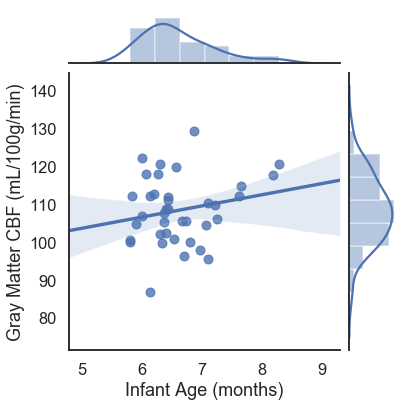

(0.20588335164899418, 0.21494169777565172)


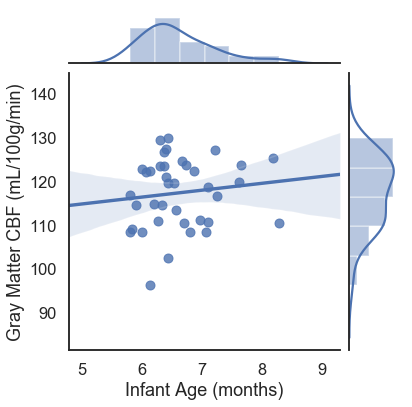

(0.12207369599252407, 0.46532148465350953)


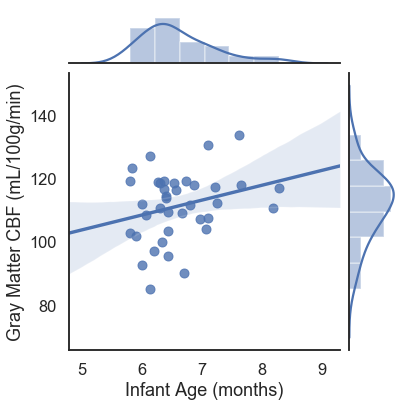

(0.26749194192716574, 0.10446359728337729)


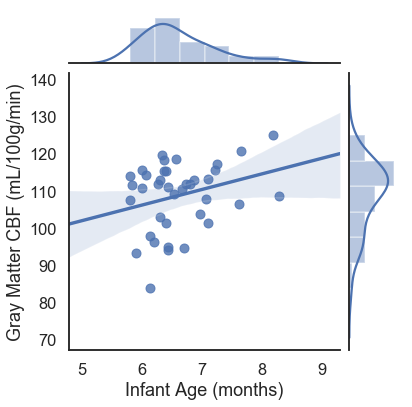

(0.28230195777480127, 0.08593942291037937)


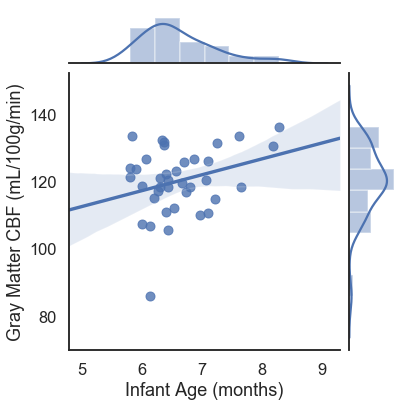

(0.2914700786789495, 0.07581558872119085)


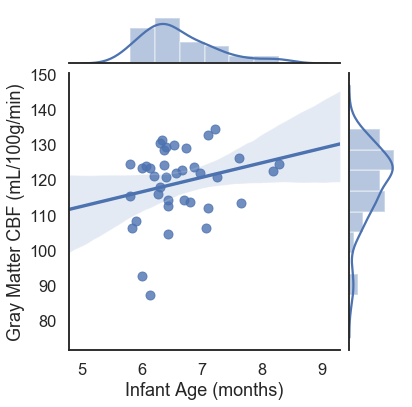

(0.2429983661725732, 0.14155087575640532)


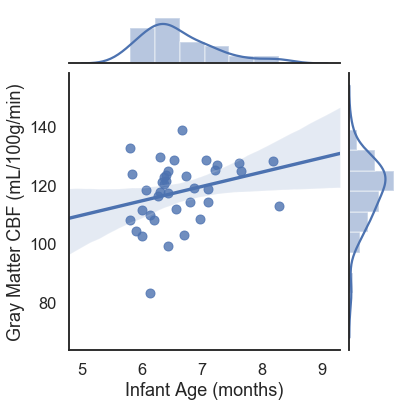

(0.27785146006658634, 0.09121639597760693)


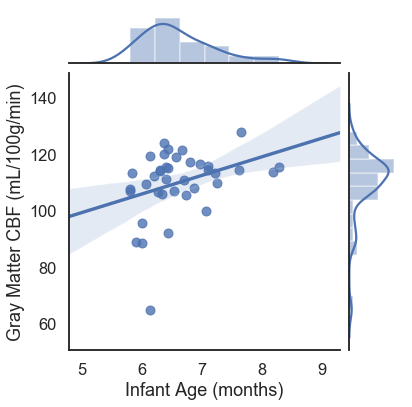

(0.3436843084148487, 0.03462889490352019)


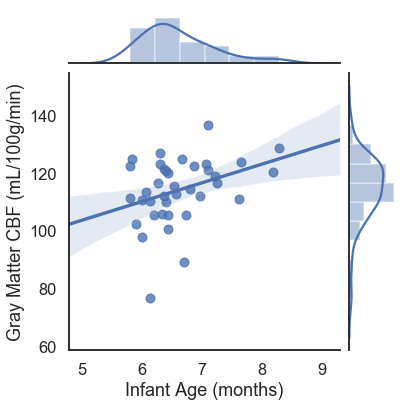

(0.34847872759889964, 0.0320228601360776)


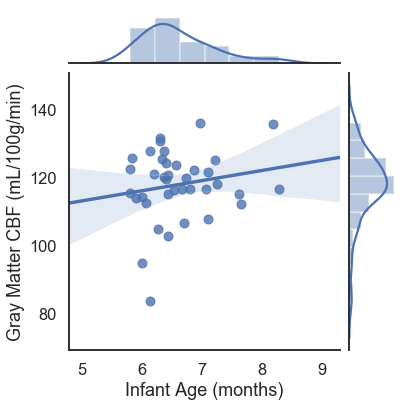

(0.1755287285125033, 0.2918382309609394)


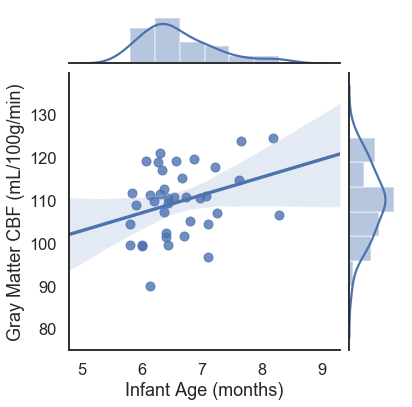

(0.3167689952532858, 0.05266075147057239)


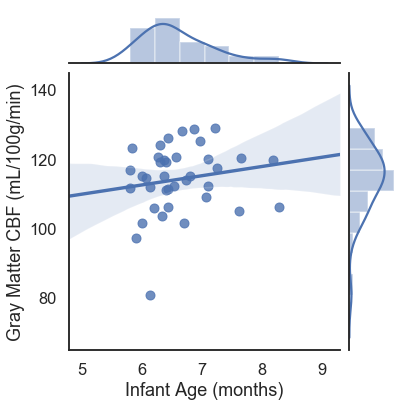

(0.1660417691770713, 0.3191062156115784)


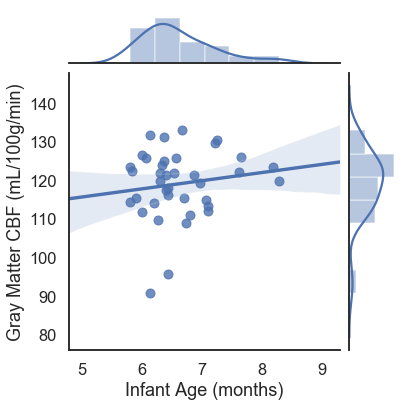

(0.14517742395283056, 0.38448686695174783)


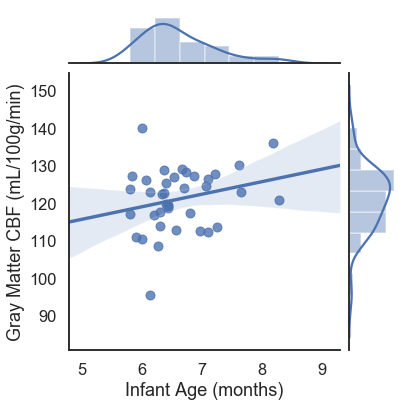

(0.24660955040782392, 0.135546531249693)


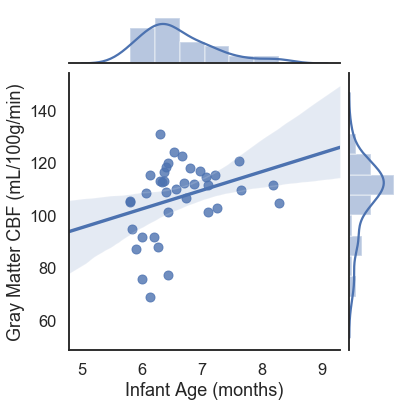

(0.31287924049864047, 0.05579699247778625)


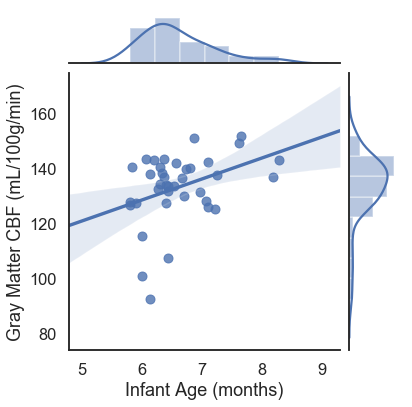

(0.37296639157599915, 0.021097696100524352)


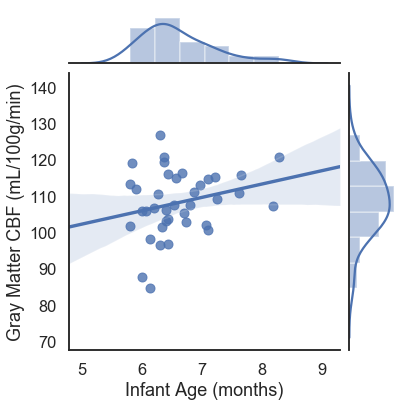

(0.25187982152130284, 0.12712463558183767)


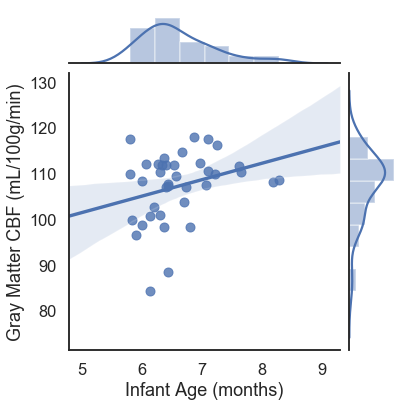

(0.29106028999136563, 0.07624722953763294)


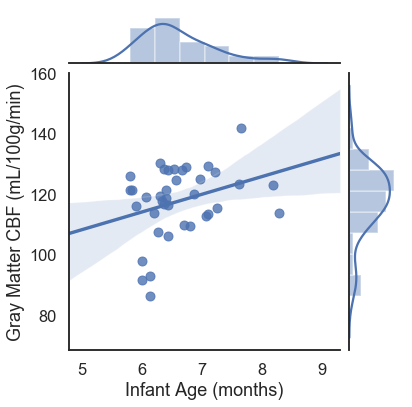

(0.30885453320595163, 0.05919704710575184)


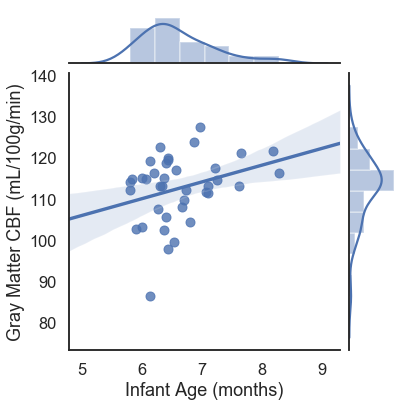

(0.3073124934475986, 0.0605425688163613)


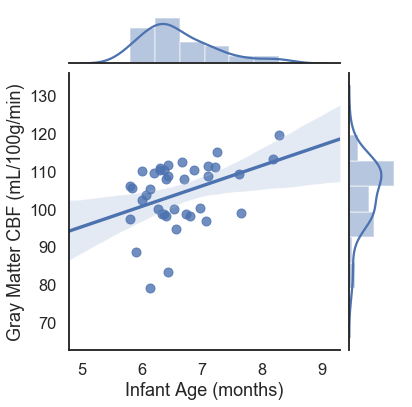

(0.3839187077035287, 0.01733286691414132)


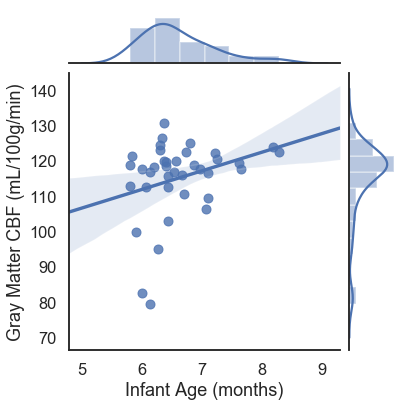

(0.29655838277477353, 0.07061348302244291)


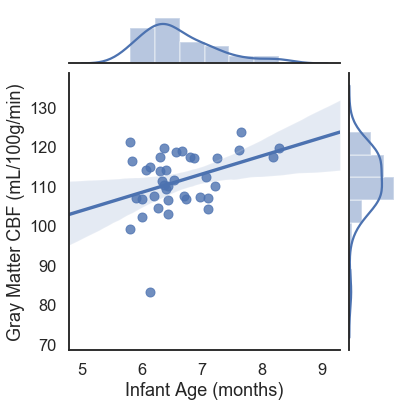

(0.37021942916082434, 0.022142122736920903)


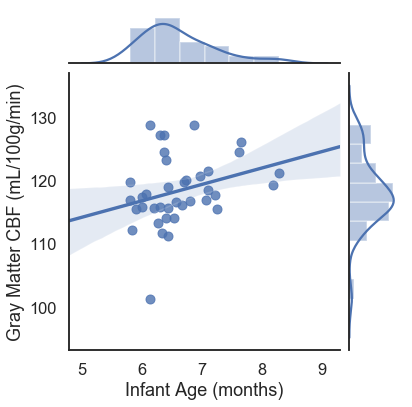

(0.28905292146004313, 0.07838943167841333)


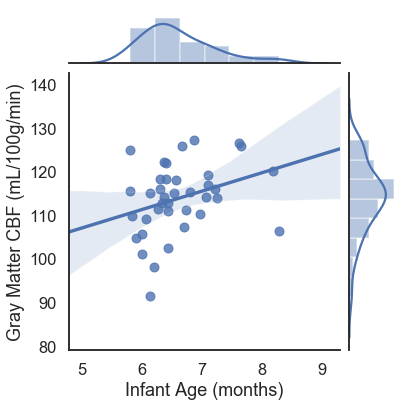

(0.31963705047597796, 0.050439931715702234)


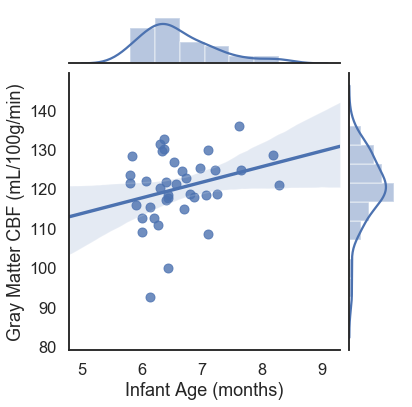

(0.2743559177610981, 0.0955332091167033)


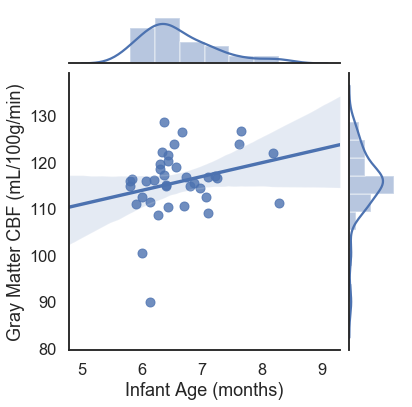

(0.25707305524225416, 0.11921345676150968)


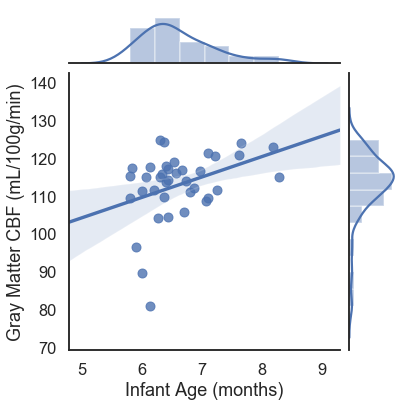

(0.3675032288187833, 0.023216831930448583)


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas import read_csv, DataFrame
from scipy.stats import pearsonr

sns.set(context='talk', style='white')

data = read_csv('/Users/catcamacho/Box/SNAP/BABIES/proc/asl_group_affect/affect_cluster_betas/_get_betas8/clusters_extracted_betas.csv', index_col=0)
clusts = data.columns
clusts = clusts[3:]
print(clusts)
for cluster in clusts:
    sns.jointplot(x='age',y=cluster,data=data,kind='reg')
    plt.xlabel('Infant Age (months)')
    plt.ylabel('Gray Matter CBF (mL/100g/min)')
    plt.savefig('/Users/catcamacho/Dropbox/Projects/infant_ASL/paper/strictagePlot_'+ cluster +'.svg')
    plt.show()
    print(pearsonr(data['age'],data[cluster]))



In [29]:
from pandas import read_csv
from scipy.stats import spearmanr
from numpy import round
file = '/Users/catcamacho/Box/SNAP/BABIES/results/5predictors.csv'
data=read_csv(file,index_col=None)
data.head()

rho, pval = spearmanr(data.values)
print(data.columns)
print(round(rho,decimals=3))
print(round(pval,decimals=3))

Index(['TNA', 'TSR', 'AR', 'SR', 'Age'], dtype='object')
[[ 1.    -0.117 -0.054 -0.208  0.102]
 [-0.117  1.    -0.336  0.066  0.237]
 [-0.054 -0.336  1.     0.176  0.053]
 [-0.208  0.066  0.176  1.    -0.176]
 [ 0.102  0.237  0.053 -0.176  1.   ]]
[[0.    0.483 0.746 0.209 0.543]
 [0.483 0.    0.039 0.696 0.153]
 [0.746 0.039 0.    0.29  0.752]
 [0.209 0.696 0.29  0.    0.289]
 [0.543 0.153 0.752 0.289 0.   ]]


In [17]:
# Find the upper percentage of t-stats with respect to age
from nibabel import load
from numpy import nanpercentile

file = '/Users/catcamacho/Box/SNAP/BABIES/proc/asl_group_affect/tstat_files/vol0008.nii.gz'

img =load(file)
data = img.get_data()
data = data[data>0]

print(nanpercentile(data, 95,interpolation='linear'))

31.33217124938965


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':
